Search.01
    1. Formalisierung
        Zustände : Pferdposition(links/rechts), Elben links(0-3), Orks links(0-3)
        Aktionen : Anzahl Elben, Anzahl Orks, Richtung, wobei gilt : 1< Anzahl Elben+Orks <2
        Startzustand : 3 Orks und Elben links, Pferd links
        Endzustand : 0 Orks und Elben links, Pferd rechts

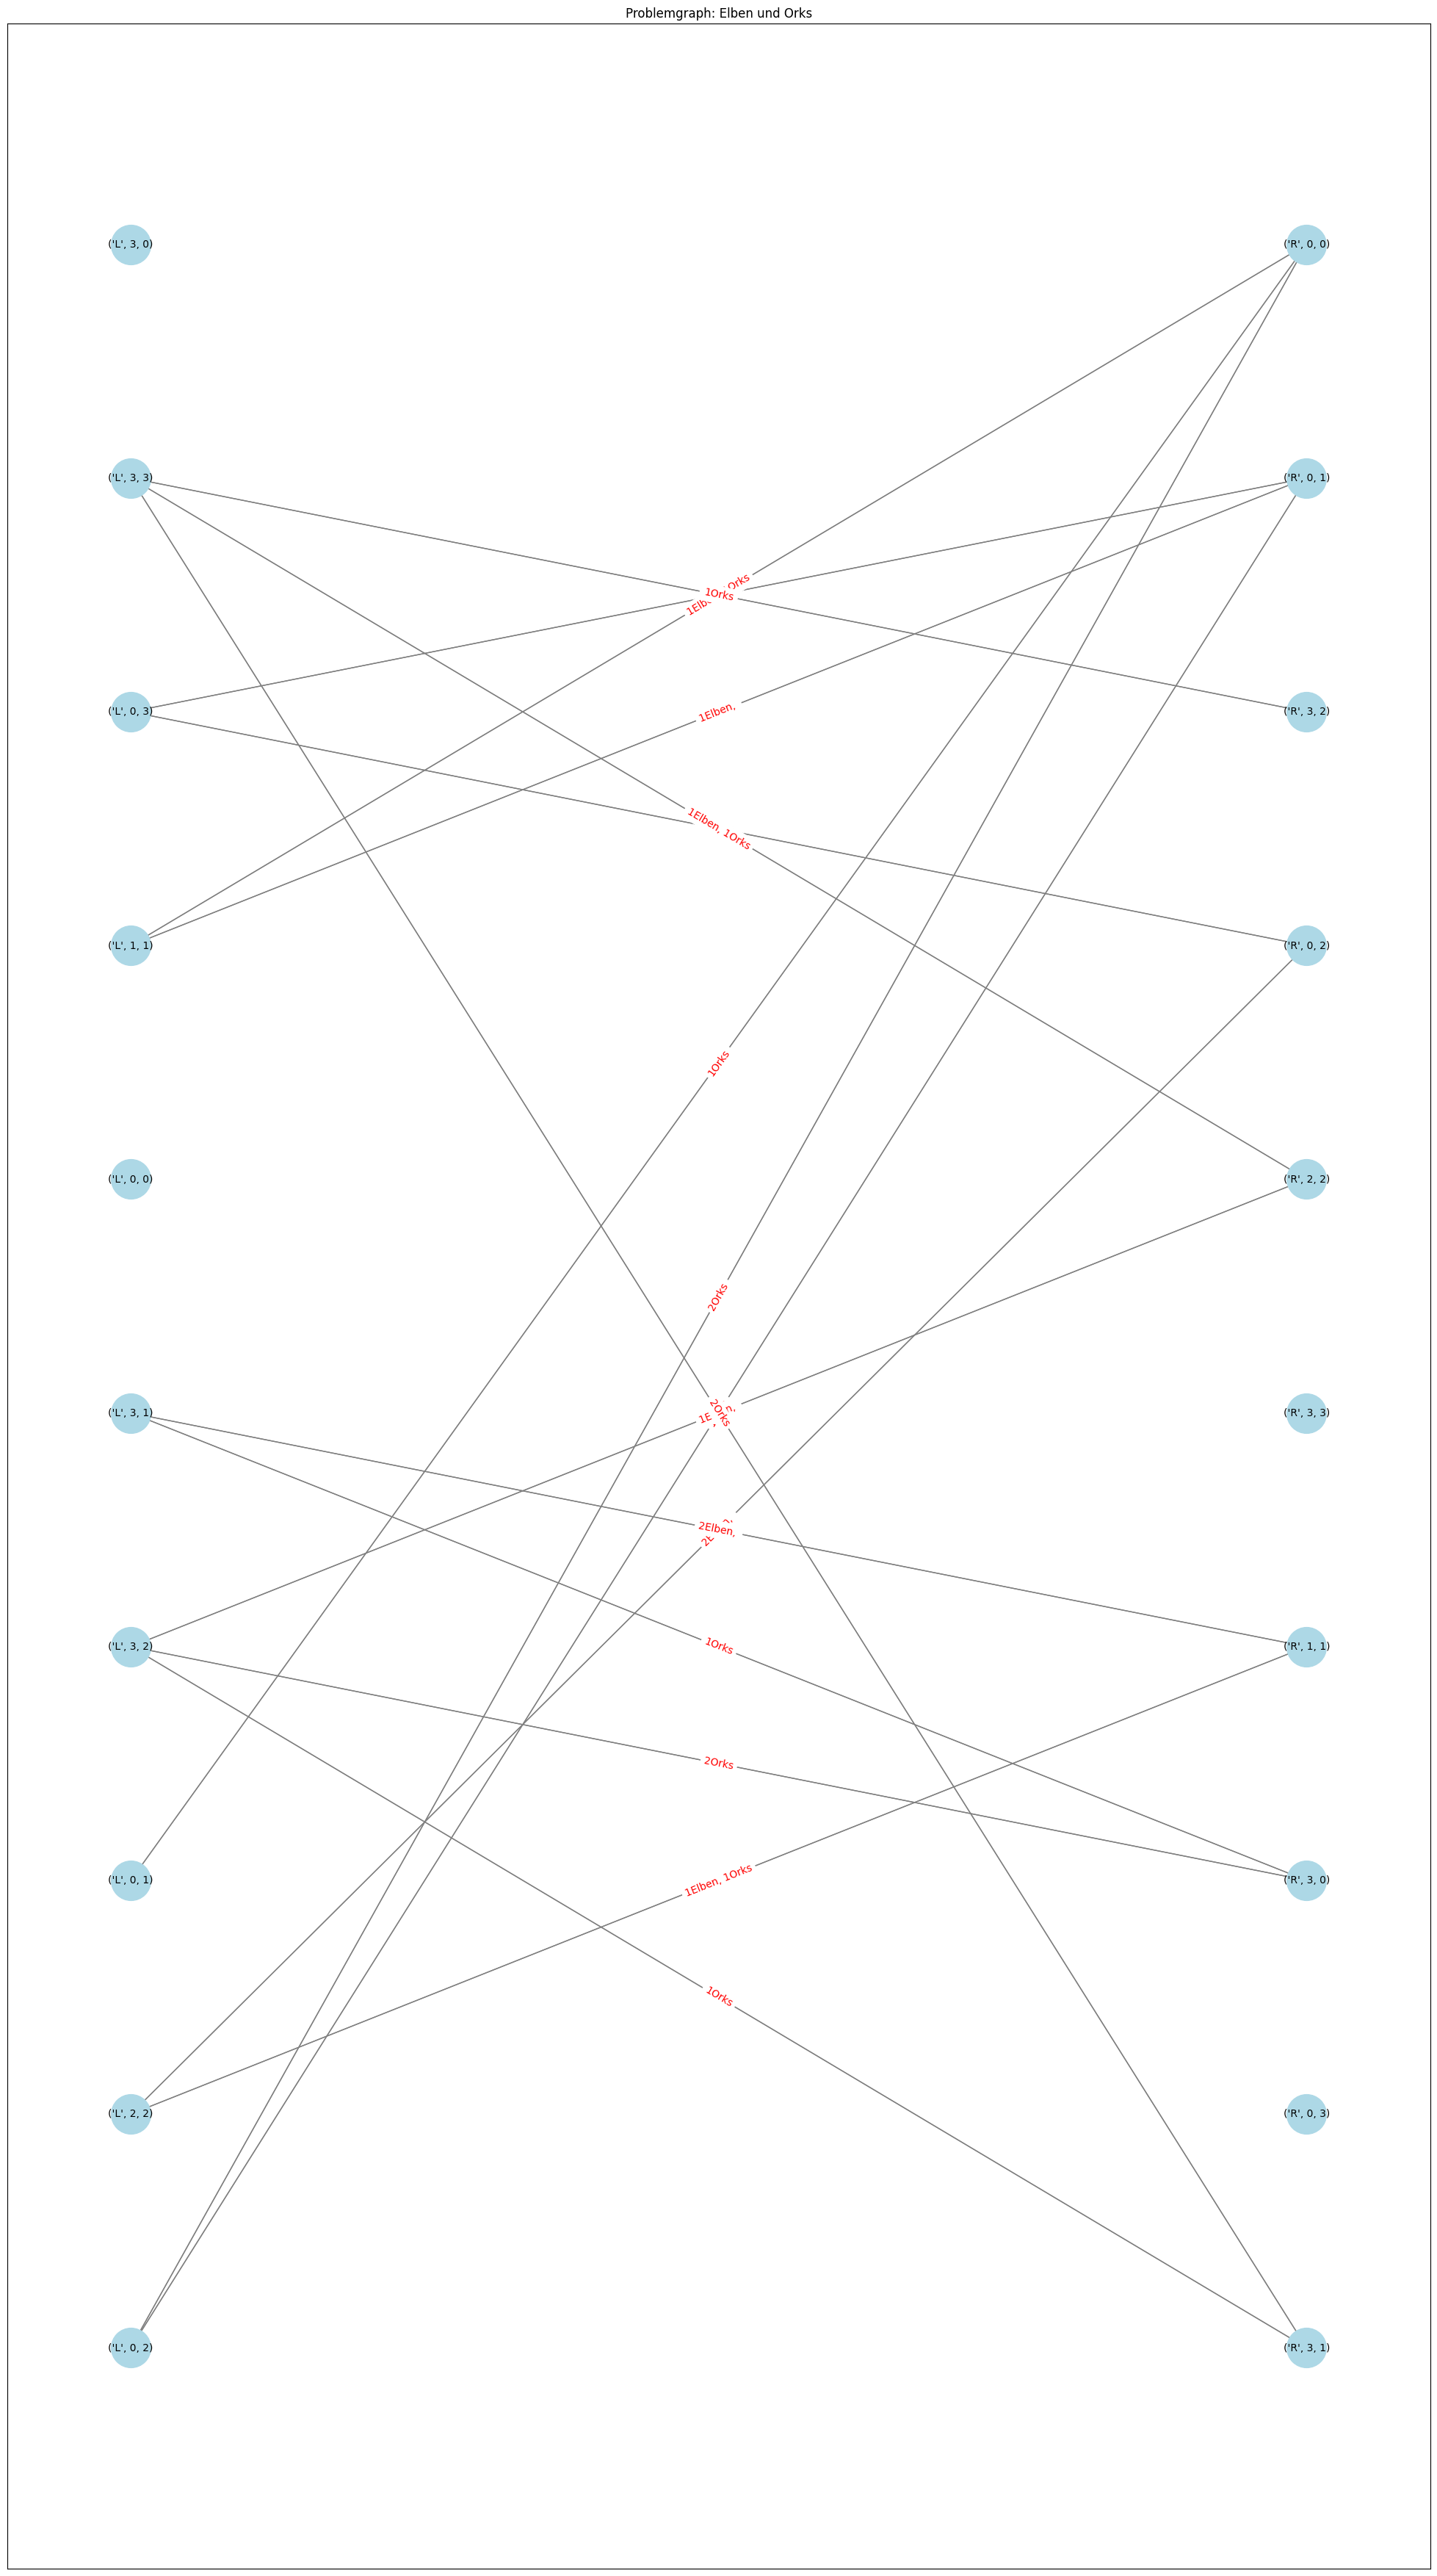

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

MAX_ELVES = 3
MAX_ORKS = 3
HORSE_CAPACITY = 2

def checkStateValidity(elvesLeft, orksLeft):
    # claculate Elves/Orks on right side
    elvesRight = MAX_ELVES - elvesLeft
    orksRight = MAX_ORKS - orksLeft

    # Compare Ork/Elf count for one side
    def tooManyOrks(elvesCount, orkCount):
        return elvesCount == 0 or elvesCount >= orkCount # Assuming that more Orks than elves are allowed if there are no elves

    # Check validity for both sides
    return (
        0 <= elvesLeft <= MAX_ELVES and 0 <= orksLeft <= MAX_ORKS and
        tooManyOrks(elvesLeft, orksLeft) and
        tooManyOrks(elvesRight, orksRight)
    )

# Generate all valid states
states = []
## All possible combinations of elf and ork counts
for elves in range(0, MAX_ELVES + 1):
    for orks in range(0, MAX_ORKS + 1):
        for side in ['L', 'R']: # Two states for each combination, depending on where the horse is
            if checkStateValidity(elves, orks):
                states.append((side, elves, orks))

# Create graph with states as nodes
G = nx.DiGraph()
G.add_nodes_from(states)

# All possible actions/moves
actions = [
    (1, 0),  # 1 Elf
    (2, 0),  # 2 Elves
    (0, 1),  # 1 Ork
    (0, 2),  # 2 Orks
    (1, 1),  # 1 Elf + 1 Ork
]

# Generate connections
for state in states:
    # Grab values stored in states[]
    side, elvesLeft, orksLeft = state
    # Calculate Elves/Orks on right side
    elvesRight = MAX_ELVES - elvesLeft
    orksRight = MAX_ORKS - orksLeft

    for movedElves, movedOrks in actions:
        if side == 'L': # Horse goes to the right
            if elvesLeft >= movedElves and orksLeft >= movedOrks:
                # Make resulting state based on the action
                newElvesLeft = elvesLeft - movedElves
                newOrksLeft = orksLeft - movedOrks
                newState = ('R', newElvesLeft, newOrksLeft)

                ## If resulting state is valid, add a connection
                if newState in states:
                    label = f"{movedElves}Elben, " if movedElves > 0 else ""
                    label += f"{movedOrks}Orks" if movedOrks > 0 else ""
                    G.add_edge(state, newState, label=label)
        else: # Horse goes to the left
            if elvesRight >= movedElves and orksRight >= movedOrks:
                # Make resulting state based on the action
                newElvesLeft = elvesLeft + movedElves
                newOrksLeft = orksLeft + movedOrks
                newState = ('L', newElvesLeft, newOrksLeft)

                ## If resulting state is valid, add a connection
                if newState in states:
                    label = f"{movedElves}Elben, " if movedElves > 0 else ""
                    label += f"{movedOrks}Orks" if movedOrks > 0 else ""
                    G.add_edge(state, newState, label=label)

# Create the graph
plt.figure(figsize=(25, 45))
## Layout for two sets of nodes
leftNodes = [state for state in states if state[0] == 'L']
rightNodes = [state for state in states if state[0] == 'R']
pos = nx.bipartite_layout(G, nodes=leftNodes, scale=5.0)
## Draw nodes
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=1500)
nx.draw_networkx_labels(G, pos, font_size=10)
## Draw Connections
nx.draw_networkx_edges(G, pos, arrows=True, arrowstyle='->', edge_color='gray')
nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, 'label'), font_color='red', font_size=10)

plt.title("Problemgraph: Elben und Orks")
plt.show()


Search.02 Suchverfahren
    1. Wegfindung Würzburg->München (manuell)
        1. Tiefensuche
            Start in Würzburg, Markiere als besucht
            Gehe nach Nürnberg, Markiere als besucht
            Gehe Nach München, Ende
        2 Breitensuche
            Start in Würzburg, Markiere als besucht, Nürnberg, Erfurt und Frankfurt in die Queue
            Gehe nach Nürnberg, Markiere als besucht, München und Stuttgart in die Queue
            Zurück nach Würzburg
            Gehe nach Erfurt, Markiere als besucht
            Zurück nach Würzburg
            Gehe nach Frankfurt, markiere als besucht, Mannheim und Kassel in die Queue
            Zurück nach Würzburg
            Gehe nach Nürnberg->München (Da nun das erste Element der Queue), Ende
        3. A*
            Start in Würzburg
            Verfügbare Knoten und f(n):
                Nürnberg : f(n) = 103km + 537km = 640km
                Erfurt : f(n) = 186km + 400km = 586km
                Frankfurt : f(n) = 217km + 100km = 317km
            Frankfurt niedrigstes f(n), gehe dorthin
            Verfübare Knoten und f(n) :
                Mannheim : f(n) = 302km + 200km = 502km
                Kassel : f(n) = 390 km + 460km = 850km
                Würzburg nicht zur Wahl, da "keine Zyklen"-Verbesserung
            Mannheim, niedrigstes f(n), gehe dorthin
            Gehe nach Karlsruhe->Augsburg->München (Jeweils die einzige Option), Ende
    2. Restkostenschätzungen
        Die Schätzungen dürfen nicht genutzt werden, da sie teilweise höher sind als die optimalen Restkosten und somit überschätzen (z.B. optimal Nürnberg->München=167km, Schätzung 537km)

        Neuer A* Versuch: Annahme dass h(n) gleich dem optimalen Restweg ist
            Start in Würzburg
            Verfügbare Knoten von Würzburg:
                Nürnberg : f(n) = 103km + 167km = 270km
                Erfurt : f(n) = 186km + 456km = 642km
                Frankfurt : f(n) = 217km + 487km = 704km
            Nürnberg niedrigstes f(n), gehe dorthin
            Verfügbare Knoten von Nürnberg:
                Stuttgart : f(n) = 286km + 350km = 533km
                München : f(n) = 270km + 0km = 270km
            München niedrisgtes f(n), gehe dorthin, Ende

Search.03 Dominanz
    1. Was bedeutet “Eine Heuristik h 1 ( n ) dominiert eine Heuristik h 2 ( n ) ”?
        Eine Heuristik h1(n) dominiert eine andere Heuristik, wenn sie in allen komponenten (hier g(n) UND h(n)) besser ist.
    2. Wie wirkt sich die Nutzung einer dominierenden Heuristik h 1 ( n ) in A* aus (im Vergleich zur Nutzung einer Heuristik h 2 , die von h 1 dominiert wird)?
        Eine dominante Heuristik ist im Vergleich genauer bei der Einschätzung des verbleibenden Weges und damit häufig schneller, da weniger unnötige Knoten besucht werden.
    3. Beispiel
        In den gegebenen Schätzungen ist h(Frankfurt)=100km, während h(Erfurt)=400km, also dominiert h(Frankfurt). Der Weg über Frankfurt ist in diesem Fall auch schneller, da Erfurt hier eine Sackgasse ist.

Search.04 Optimalität
    A* ist in der Tree-Search-Variante bei Nutzung einer zulässigen Heuristik optimal, da es sowohl die Heuristik h(n) als auch die tatsächlichen Kosten zu jedem Knoten g(n) berücksichtigt. Ein suboptimaler Pfad würde nie ganz erkundet werden, da g(n) groß genug wird, dass der optimale Pfad ein niedrigeres f(n) besitzt, vorausgesetzt dass h(n) zulässig ist, also die verbleibenden Kosten des Knotens nie überschätzt.

